In [1]:
import torch
import os
import shutil
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.4 MB/s eta 0:00:00


In [4]:
!git clone https://github.com/jaysulk/AFNO-transformer.git /content/drive/MyDrive/Github/AFNO-transformer

fatal: destination path '/content/drive/MyDrive/Github/AFNO-transformer' already exists and is not an empty directory.


In [5]:
!pip install /content/drive/MyDrive/Github/AFNO-transformer/

Processing ./drive/MyDrive/Github/AFNO-transformer
  Preparing metadata (setup.py) ... done
  Created wheel for afno: filename=afno-0.0.1-py3-none-any.whl size=16040 sha256=9faa912eb2169d9074d556dc86af98a9e022644157b84bf3e78f6fa2349c4176
  Stored in directory: /root/.cache/pip/wheels/77/48/0f/87c770d240c74cb454027fb3d5af919cb6ed10857b9caf1bda
Successfully built afno


In [6]:
from afno import AFNO1D,AFNO2D

In [7]:
checkpoints = '/content/drive/MyDrive/colab_files/imagenet64/'
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Assuming you've already imported or defined AFNO2D

class ModelWithAFNO(nn.Module):
    def __init__(self):
        super(ModelWithAFNO, self).__init__()

        # Adjusting the layers for MNIST
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # Input channels changed to 1
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling

        # Presuming AFNO2D is a custom layer you have defined elsewhere
        self.afno = AFNO2D(hidden_size=128, num_blocks=4, sparsity_threshold=0.01,
                          hard_thresholding_fraction=1, hidden_size_factor=1)

        # Adjusting the classifier for MNIST
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.5),  # Adjusted dropout
            nn.Linear(128, 10),  # Output layer for 10 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        B, C, H, W = x.size()
        x = x.reshape(B, H*W, C)
        x = self.afno(x)
        x = x.reshape(B, C, H, W)
        x = self.classifier(x)
        return x

# Model instantiation
model = ModelWithAFNO()


# Model instantiation
model = ModelWithAFNO()

In [9]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005,
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
  net.to(device)
  net.train()
  losses = []
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

  # Load previous training state
  if state:
      net.load_state_dict(state['net'])
      optimizer.load_state_dict(state['optimizer'])
      start_epoch = state['epoch']
      losses = state['losses']

  # Fast forward lr schedule through already trained epochs
  for epoch in range(start_epoch):
    if epoch in schedule:
      print ("Learning rate: %f"% schedule[epoch])
      for g in optimizer.param_groups:
        g['lr'] = schedule[epoch]

  for epoch in range(start_epoch, epochs):
    sum_loss = 0.0

    # Update learning rate when scheduled
    if epoch in schedule:
      print ("Learning rate: %f"% schedule[epoch])
      for g in optimizer.param_groups:
        g['lr'] = schedule[epoch]

    for i, batch in enumerate(dataloader, 0):
        inputs, labels = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # autograd magic, computes all the partial derivatives
        optimizer.step() # takes a step in gradient direction

        losses.append(loss.item())
        sum_loss += loss.item()

        if i % print_every == print_every-1:    # print every 10 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
            sum_loss = 0.0
    if checkpoint_path:
      state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
      torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
  return losses

def accuracy(net, dataloader):
  net.to(device)
  net.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

def precision_recall_f1_score(net, dataloader):
    net.to(device)
    net.eval()

    true_positives = 0
    false_positives = 0
    false_negatives = 0
    true_negatives = 0

    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch[0].to(device), batch[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)

            for label, prediction in zip(labels, predicted):
                if label == prediction == 1:
                    true_positives += 1
                elif prediction == 1 and label != prediction:
                    false_positives += 1
                elif label == 1 and label != prediction:
                    false_negatives += 1
                elif label == prediction == 0:
                    true_negatives += 1

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

def get_confusion_matrix(net, dataloader, device):
    net.to(device)
    net.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch[0].to(device), batch[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    return confusion_matrix(all_labels, all_predictions)

def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

In [10]:
import torchvision
import torchvision.transforms as transforms
import torch

def get_mnist_data():
    # Transformations for the MNIST dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalizing the dataset
    ])

    # Loading the MNIST training set
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                          transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True,
                                              num_workers=2)

    # Loading the MNIST test set
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True,
                                         transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False,
                                             num_workers=2)

    # MNIST has 10 classes, corresponding to digits 0-9
    classes = list(map(str, range(10)))
    return {'train': trainloader, 'test': testloader, 'classes': classes}

mnist_data = get_mnist_data()

100%|██████████| 9912422/9912422 [00:00<00:00, 72908762.13it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 15943102.64it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29203772.55it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15191809.22it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [11]:
start_time = time.time()
cifar_losses = train(model, mnist_data['train'], epochs=20, schedule={0:.01, 5:.001, 15:.0001}, print_every=1000)
print("Testing accuracy: %f" % accuracy(model, mnist_data['test']))
training_time = time.time() - start_time

Learning rate: 0.010000
Learning rate: 0.001000
Learning rate: 0.000100
Testing accuracy: 0.976200


In [12]:
training_time

384.33083629608154

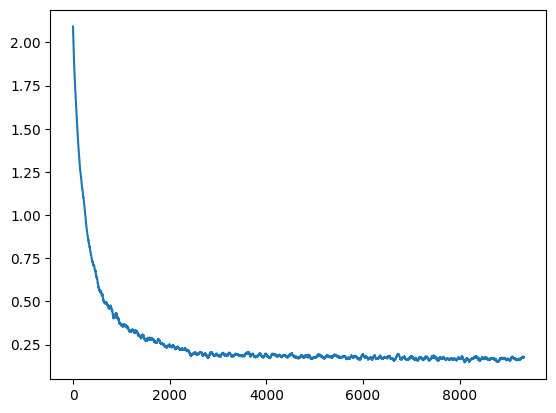

In [13]:
plt.plot(smooth(cifar_losses,50))

In [14]:
with open('/content/drive/My Drive/AFNO_MNIST_accuracy.pkl', 'wb') as file:
    # Pickle the list and write it to the file
    pickle.dump(cifar_losses, file)

In [15]:
precision, recall, f1_score = precision_recall_f1_score(model, mnist_data['test'])
print(precision,
recall,
f1_score)

0.9920704845814978 0.9920704845814978 0.9920704845814978


In [16]:
cm = get_confusion_matrix(model, mnist_data['test'],device)

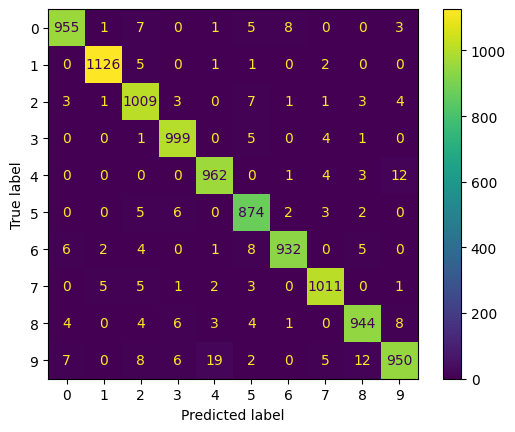

In [17]:
ConfusionMatrixDisplay(cm).plot()